# Anti Money Laundering (AML) - XGBoost Evaluation


*   Data Preprocessing- LI Small Transaction in IBM



In [13]:
#import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

#dataset for LI small transaction
df = pd.read_csv('LI-Small_Trans.csv')

In [14]:
# import preprocessing libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder


In [15]:
#rename the target label
df = df.rename(columns={'Is Laundering': 'Is_Laundering'})

In [16]:
#Select columns of object type
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols

['Timestamp',
 'Account',
 'Account.1',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

In [17]:
# Use Label Encoding to quantify object type columns
label_encoder = LabelEncoder()
for col in object_cols:
    if col != 'Payment Format':
        df[col] = label_encoder.fit_transform(df[col])

# Sort by payment complexity
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Use map method to encode Payment Format column
df['Payment Format'] = df['Payment Format'].map(payment_map)

df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
0,8,11.0,150,11.0,108,3195403.00,12,3195403.00,12,7.0,0.0
1,21,3402.0,1151,3402.0,961,1858.96,12,1858.96,12,7.0,0.0
2,0,11.0,150,1120.0,4283,592571.00,12,592571.00,12,2.0,0.0
3,16,3814.0,4972,3814.0,4288,12.32,12,12.32,12,7.0,0.0
4,0,20.0,4975,20.0,4291,2941.56,12,2941.56,12,7.0,0.0


In [18]:
# Separate labels from the dataset
labels = df['Is_Laundering']
df = df.drop('Is_Laundering', axis=1)

# Convert Timestamp column to timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp']).astype(int) / 10**9

#Normalize the data set
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df_normalized = scaler.transform(df)

# Convert the normalized data into a DataFrame object and set the column names
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)


# Add the label column to the regression-normalized data set
df_normalized['Is_Laundering'] = labels.tolist()

# Output the normalized data
print(df_normalized.head())


   Timestamp  From Bank   Account   To Bank  Account.1  Amount Received  \
0  -0.448276  -0.999942 -0.998639 -0.999942  -0.998992        -0.999142   
1   0.448276  -0.981949 -0.989558 -0.981949  -0.991033        -1.000000   
2  -1.000000  -0.999942 -0.998639 -0.994057  -0.960034        -0.999841   
3   0.103448  -0.979763 -0.954893 -0.979763  -0.959987        -1.000000   
4  -1.000000  -0.999894 -0.954865 -0.999894  -0.959959        -0.999999   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  \
0                 0.6    -0.999142               0.6        1.000000   
1                 0.6    -1.000000               0.6        1.000000   
2                 0.6    -0.999841               0.6       -0.666667   
3                 0.6    -1.000000               0.6        1.000000   
4                 0.6    -0.999999               0.6        1.000000   

   Is_Laundering  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [19]:
# Select rows with Is_Laundering column as 1
df_laundering = df_normalized.loc[df_normalized['Is_Laundering'] == 1]

# Output the selected data
print(df_normalized.count())
df_laundering.count()

Timestamp             294759
From Bank             294758
Account               294759
To Bank               294758
Account.1             294759
Amount Received       294758
Receiving Currency    294759
Amount Paid           294758
Payment Currency      294759
Payment Format        294758
Is_Laundering         294758
dtype: int64


Timestamp             10
From Bank             10
Account               10
To Bank               10
Account.1             10
Amount Received       10
Receiving Currency    10
Amount Paid           10
Payment Currency      10
Payment Format        10
Is_Laundering         10
dtype: int64

In [20]:
# Shuffle the data before creating the subsamples since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

df_normalized = df_normalized.sample(frac=1)

fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 1]
non_fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
198739,-0.793103,-0.999629,-0.999991,-0.388057,-0.342192,-0.997414,-0.466667,-0.997414,-0.466667,-1.000000,1.0
15639,0.931034,-0.984825,-0.890906,-0.984825,-0.829049,-0.999998,0.600000,-0.999998,0.600000,-0.666667,0.0
65815,0.655172,-0.883105,-0.044309,-0.883105,-0.071161,-1.000000,0.600000,-1.000000,0.600000,1.000000,0.0
127003,-1.000000,-0.936499,0.636837,0.323027,0.623879,-1.000000,0.600000,-1.000000,0.600000,-0.333333,1.0
276018,-0.241379,-0.999629,-0.999982,-0.947068,-0.611730,-0.999979,0.866667,-0.999979,0.866667,-1.000000,1.0


<ipython-input-21-400b620334c3>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')


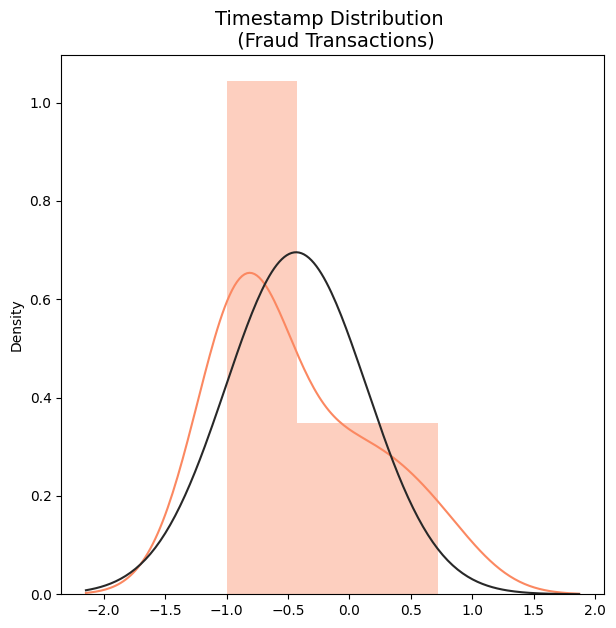

In [21]:
from scipy.stats import norm
import seaborn as sns

f, ax = plt.subplots(figsize=(7, 7))

Timestamp_fraud_dist = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')
ax.set_title('Timestamp Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [22]:
#Remove timestamp outliers:
Timestamp_fraud = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
q25, q75 = np.percentile(Timestamp_fraud, 25), np.percentile(Timestamp_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
Timestamp_iqr = q75 - q25
print('iqr: {}'.format(Timestamp_iqr))

Timestamp_cut_off = Timestamp_iqr * 1.5
Timestamp_lower, Timestamp_upper = q25 - Timestamp_cut_off, q75 + Timestamp_cut_off
print('Cut Off: {}'.format(Timestamp_cut_off))
print('Timestamp Lower: {}'.format(Timestamp_lower))
print('Timestamp Upper: {}'.format(Timestamp_upper))

outliers = [x for x in Timestamp_fraud if x < Timestamp_lower or x > Timestamp_upper]
print('Feature Timestamp Outliers for Fraud Cases: {}'.format(len(outliers)))
print('Timestamp outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['Timestamp'] > Timestamp_upper) | (new_df['Timestamp'] < Timestamp_lower)].index)

new_df.head()

Quartile 25: -0.8448275862068966 | Quartile 75: -0.03448275862068981
iqr: 0.8103448275862067
Cut Off: 1.21551724137931
Timestamp Lower: -2.0603448275862064
Timestamp Upper: 1.1810344827586203
Feature Timestamp Outliers for Fraud Cases: 0
Timestamp outliers:[]


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
198739,-0.793103,-0.999629,-0.999991,-0.388057,-0.342192,-0.997414,-0.466667,-0.997414,-0.466667,-1.000000,1.0
15639,0.931034,-0.984825,-0.890906,-0.984825,-0.829049,-0.999998,0.600000,-0.999998,0.600000,-0.666667,0.0
65815,0.655172,-0.883105,-0.044309,-0.883105,-0.071161,-1.000000,0.600000,-1.000000,0.600000,1.000000,0.0
127003,-1.000000,-0.936499,0.636837,0.323027,0.623879,-1.000000,0.600000,-1.000000,0.600000,-0.333333,1.0
276018,-0.241379,-0.999629,-0.999982,-0.947068,-0.611730,-0.999979,0.866667,-0.999979,0.866667,-1.000000,1.0




# Evaluation -LI Small Transaction in IBM
- Using Accuracy Score:


In [23]:
# Split the dataset into features and target variable
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1
}

# Train the XGBoost model and record the evaluation results
num_rounds = 2000 # Number of boosting rounds
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)

# Evaluate the XGBoost model
y_pred = bst.predict(dtest)
y_pred = np.round(y_pred)
test_score = accuracy_score(y_test, y_pred)
print("XGBoost has a test score of", round(test_score, 2) * 100, "% accuracy score")

[0]	train-logloss:0.64645	train-error:0.06250	test-logloss:0.66696	test-error:0.25000
[1]	train-logloss:0.60578	train-error:0.06250	test-logloss:0.61950	test-error:0.25000
[2]	train-logloss:0.56594	train-error:0.06250	test-logloss:0.57236	test-error:0.00000
[3]	train-logloss:0.53447	train-error:0.06250	test-logloss:0.55586	test-error:0.00000
[4]	train-logloss:0.50073	train-error:0.06250	test-logloss:0.53940	test-error:0.25000
[5]	train-logloss:0.47060	train-error:0.06250	test-logloss:0.50126	test-error:0.00000
[6]	train-logloss:0.44694	train-error:0.06250	test-logloss:0.49044	test-error:0.25000
[7]	train-logloss:0.43167	train-error:0.06250	test-logloss:0.48398	test-error:0.25000
[8]	train-logloss:0.40799	train-error:0.06250	test-logloss:0.47573	test-error:0.25000
[9]	train-logloss:0.39494	train-error:0.06250	test-logloss:0.47235	test-error:0.25000
[10]	train-logloss:0.38075	train-error:0.06250	test-logloss:0.46713	test-error:0.25000
[11]	train-logloss:0.36511	train-error:0.06250	test-l

- Using metrics report

In [24]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



- Using Confusion matrix

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[2 0]
 [1 1]]




*   Data preprocessing - HI Small Transaction in IBM



In [28]:
# import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

#dataset for HI small transaction
df = pd.read_csv('HI-Small_Trans.csv')

In [29]:
# import preprocessing libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

In [30]:
#rename target label
df = df.rename(columns={'Is Laundering': 'Is_Laundering'})

In [31]:
#Select columns of object type
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols

['Timestamp',
 'Account',
 'Account.1',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

In [32]:
# Use Label Encoding to quantify object type columns
label_encoder = LabelEncoder()
for col in object_cols:
    if col != 'Payment Format':
        df[col] = label_encoder.fit_transform(df[col])

#Sort by payment complexity
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Use map method to encode Payment Format column
df['Payment Format'] = df['Payment Format'].map(payment_map)

df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
0,20,10,900,10,749,3697.34,12,3697.34,12,7.0,0.0
1,20,3208,941,1,784,0.01,12,0.01,12,2.0,0.0
2,0,3209,942,3209,778,14675.57,12,14675.57,12,7.0,0.0
3,2,12,947,12,781,2806.97,12,2806.97,12,7.0,0.0
4,6,10,948,10,782,36682.97,12,36682.97,12,7.0,0.0


In [33]:
#Separate label from dataset
labels = df['Is_Laundering']
df = df.drop('Is_Laundering', axis=1)

#Convert Timestampt column to timestampt
df['Timestamp'] = pd.to_datetime(df['Timestamp']).astype(int) / 10**9

#Normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df_normalized = scaler.transform(df)

#Convert the normalized data into a Dataframe object and set the column names
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)

#Add the label column into regression-normalized data set
df_normalized['Is_Laundering'] = labels.tolist()

#Output the normalized data
print(df_normalized.head())

   Timestamp  From Bank   Account   To Bank  Account.1  Amount Received  \
0  -0.952210  -0.999949 -0.994651 -0.999949  -0.995482             -1.0   
1  -0.952210  -0.981998 -0.994408 -1.000000  -0.995271             -1.0   
2  -1.000000  -0.981992 -0.994402 -0.981992  -0.995307             -1.0   
3  -0.995221  -0.999938 -0.994372 -0.999938  -0.995289             -1.0   
4  -0.985663  -0.999949 -0.994366 -0.999949  -0.995283             -1.0   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  \
0            0.714286         -1.0          0.714286        1.000000   
1            0.714286         -1.0          0.714286       -0.666667   
2            0.714286         -1.0          0.714286        1.000000   
3            0.714286         -1.0          0.714286        1.000000   
4            0.714286         -1.0          0.714286        1.000000   

   Is_Laundering  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [34]:
# Select rows with Is_Laundering column as 1
df_laundering = df_normalized.loc[df_normalized['Is_Laundering'] == 1]

#Output selected data
print(df_normalized.count())
df_laundering.count()

Timestamp             653308
From Bank             653308
Account               653308
To Bank               653308
Account.1             653308
Amount Received       653308
Receiving Currency    653308
Amount Paid           653308
Payment Currency      653308
Payment Format        653307
Is_Laundering         653307
dtype: int64


Timestamp             351
From Bank             351
Account               351
To Bank               351
Account.1             351
Amount Received       351
Receiving Currency    351
Amount Paid           351
Payment Currency      351
Payment Format        351
Is_Laundering         351
dtype: int64

In [35]:
# Shuffle the data before creating the subsamples since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.
df_normalized = df_normalized.sample(frac=1)

fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 1]
non_fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
558600,0.015532,-0.999961,-0.073213,-0.999961,-0.102221,-0.999998,-0.571429,-0.999998,-0.571429,1.000000,0.0
343718,0.765830,-0.920863,-0.791624,-0.864477,-0.825158,-1.000000,-0.428571,-1.000000,-0.428571,-0.333333,1.0
593560,0.173238,-0.999843,0.360727,-0.998821,0.337369,-0.999999,-0.714286,-0.999999,-0.714286,-0.666667,1.0
197374,-0.973716,-0.847659,0.975538,-0.847659,0.974230,-1.000000,-0.428571,-1.000000,-0.428571,1.000000,0.0
324780,-0.992832,0.431165,0.976537,0.431165,0.975273,-1.000000,-0.857143,-1.000000,-0.857143,0.666667,0.0


<ipython-input-36-400b620334c3>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')


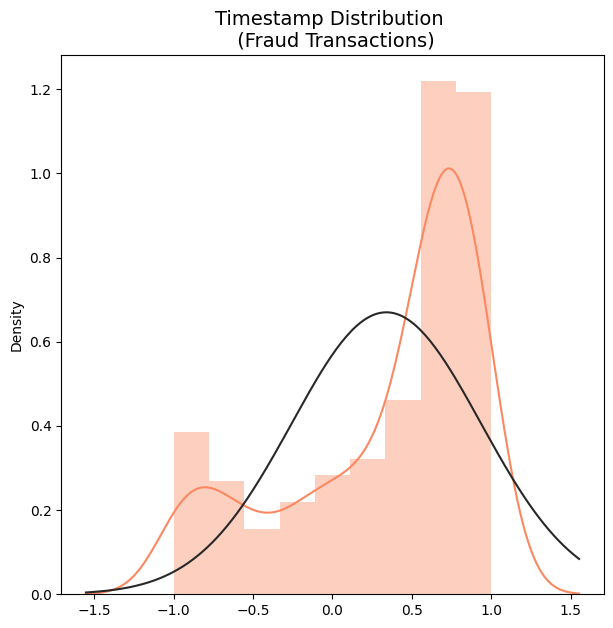

In [36]:
from scipy.stats import norm
import seaborn as sns

f, ax = plt.subplots(figsize=(7, 7))

Timestamp_fraud_dist = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')
ax.set_title('Timestamp Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [37]:
#Remove Timestamp outlier
Timestamp_fraud = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
q25, q75 = np.percentile(Timestamp_fraud, 25), np.percentile(Timestamp_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
Timestamp_iqr = q75 - q25
print('iqr: {}'.format(Timestamp_iqr))

Timestamp_cut_off = Timestamp_iqr * 1.5
Timestamp_lower, Timestamp_upper = q25 - Timestamp_cut_off, q75 + Timestamp_cut_off
print('Cut Off: {}'.format(Timestamp_cut_off))
print('Timestamp Lower: {}'.format(Timestamp_lower))
print('Timestamp Upper: {}'.format(Timestamp_upper))

outliers = [x for x in Timestamp_fraud if x < Timestamp_lower or x > Timestamp_upper]
print('Feature Timestamp Outliers for Fraud Cases: {}'.format(len(outliers)))
print('Timestamp outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['Timestamp'] > Timestamp_upper) | (new_df['Timestamp'] < Timestamp_lower)].index)

new_df.head()

Quartile 25: -0.028673835125448077 | Quartile 75: 0.7909199522102749
iqr: 0.819593787335723
Cut Off: 1.2293906810035844
Timestamp Lower: -1.2580645161290325
Timestamp Upper: 2.0203106332138594
Feature Timestamp Outliers for Fraud Cases: 0
Timestamp outliers:[]


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
558600,0.015532,-0.999961,-0.073213,-0.999961,-0.102221,-0.999998,-0.571429,-0.999998,-0.571429,1.000000,0.0
343718,0.765830,-0.920863,-0.791624,-0.864477,-0.825158,-1.000000,-0.428571,-1.000000,-0.428571,-0.333333,1.0
593560,0.173238,-0.999843,0.360727,-0.998821,0.337369,-0.999999,-0.714286,-0.999999,-0.714286,-0.666667,1.0
197374,-0.973716,-0.847659,0.975538,-0.847659,0.974230,-1.000000,-0.428571,-1.000000,-0.428571,1.000000,0.0
324780,-0.992832,0.431165,0.976537,0.431165,0.975273,-1.000000,-0.857143,-1.000000,-0.857143,0.666667,0.0




# Evaluation -HI Small Transaction in IBM
- Using Accuracy Score:

In [41]:
# Split the dataset into features and target variable
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1
}

# Train the XGBoost model and record the evaluation results
num_rounds = 2000 # Number of boosting rounds
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)

# Evaluate the XGBoost model
y_pred = bst.predict(dtest)
y_pred = np.round(y_pred)
test_score = accuracy_score(y_test, y_pred)
print("XGBoost has a test score of", round(test_score, 2) * 100, "% accuracy score")

[0]	train-logloss:0.61944	train-error:0.06774	test-logloss:0.62013	test-error:0.07092
[1]	train-logloss:0.55297	train-error:0.04991	test-logloss:0.55326	test-error:0.04255
[2]	train-logloss:0.49636	train-error:0.03922	test-logloss:0.49489	test-error:0.03546
[3]	train-logloss:0.44938	train-error:0.03387	test-logloss:0.45024	test-error:0.02837
[4]	train-logloss:0.40870	train-error:0.03743	test-logloss:0.40968	test-error:0.02837
[5]	train-logloss:0.37282	train-error:0.03743	test-logloss:0.37344	test-error:0.02837
[6]	train-logloss:0.34128	train-error:0.03387	test-logloss:0.34129	test-error:0.02837
[7]	train-logloss:0.31409	train-error:0.03387	test-logloss:0.31504	test-error:0.02837
[8]	train-logloss:0.28962	train-error:0.03387	test-logloss:0.29464	test-error:0.02837
[9]	train-logloss:0.26727	train-error:0.03387	test-logloss:0.27474	test-error:0.02837
[10]	train-logloss:0.24880	train-error:0.03030	test-logloss:0.25746	test-error:0.02837
[11]	train-logloss:0.23183	train-error:0.02852	test-l

- Using Metrics report

In [42]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.94        63
         1.0       0.96      0.95      0.95        78

    accuracy                           0.95       141
   macro avg       0.95      0.95      0.95       141
weighted avg       0.95      0.95      0.95       141



- Using Confusion matrix

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[60  3]
 [ 4 74]]
